In [18]:
from HeaderP import *
import Astraea
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
import random

In [22]:
from dustmaps.bayestar import BayestarQuery
bayestar = BayestarQuery(max_samples=2, version='bayestar2019')
print("Calculating Ebv")

Loading pixel_info ...
Loading samples ...
Loading best_fit ...
Replacing NaNs in reliable distance estimates ...
Sorting pixel_info ...
Extracting hp_idx_sorted and data_idx at each nside ...
  nside = 64
  nside = 128
  nside = 256
  nside = 512
  nside = 1024
t = 35.224 s
  pix_info:   0.696 s
   samples:  15.971 s
      best:   8.221 s
       nan:   0.652 s
      sort:   9.498 s
       idx:   0.186 s
Calculating Ebv


In [19]:
# read in McQuillian stars
McQS = pd.read_table('https://arxiv.org/src/1402.5694v2/anc/Table_1_Periodic.txt',delimiter=',',skiprows=1,names=('KID','Teff','logg','Mass','Prot','Prot_err','Rper','LPH','w','DC','Flag'))
MCQS_t2=pd.read_table('https://arxiv.org/src/1402.5694v2/anc/Table_2_Non_Periodic.txt',delimiter=',',skiprows=1,names=('KID','Teff','logg','Mass','Prot','Prot_err','LPH','w','DC'))
print('McQuillian T2 before dropping',np.shape(MCQS_t2))
MCQS_t2=MCQS_t2.dropna(subset=['Prot'])
print('McQuillian',np.shape(McQS))
print('McQuillian T2 after dropping',np.shape(MCQS_t2))

# gaia data from https://gaia-kepler.fun/
with fits.open('../FirstYearML/kepler_dr2_1arcsec.fits') as data_ga:
    gaia = pd.DataFrame(data_ga[1].data, dtype="float64")

# merge two tables with same KID
df = pd.concat([McQS[MCQS_t2.columns], MCQS_t2])

print('McQuillian T1+T2',np.shape(df))
df = pd.merge(df, gaia, left_on="KID", right_on="kepid", how="inner")


# drop duplicates
df = df.drop_duplicates(subset ="KID", keep = 'first') 
print('Cross-matched',np.shape(df))
print('Missing %d stars'%(np.shape(McQS)[0]+np.shape(MCQS_t2)[0]-np.shape(df)[0]))

McQuillian T2 before dropping (99000, 9)
McQuillian (34030, 11)
McQuillian T2 after dropping (30754, 9)
McQuillian T1+T2 (64784, 9)
Cross-matched (64624, 143)
Missing 160 stars


In [20]:
# calculate v_b's
df['v_t'],df['v_b']=Astraea.getVs(df)

In [21]:
def getDust(G, bp, rp, ebv, maxnit=100):
    """
    Compute the Gaia extinctions assuming relations from Babusieux.
    Author: Sergey Koposov skoposov@cmu.edu
    Args:
        G (float): Gaia G mag.
        bp (float): Gaia BP mag.
        rp (float): Gaia RP mag.
        ebv (float): E(B-V), extinction in B-V.
        maxnit (int): number of iterations
    Returns:
        Extinction in G,bp, rp
    """
    c1, c2, c3, c4, c5, c6, c7 = [0.9761, -0.1704,
                                  0.0086, 0.0011, -0.0438, 0.0013, 0.0099]
    d1, d2, d3, d4, d5, d6, d7 = [
        1.1517, -0.0871, -0.0333, 0.0173, -0.0230, 0.0006, 0.0043]
    e1, e2, e3, e4, e5, e6, e7 = [
        0.6104, -0.0170, -0.0026, -0.0017, -0.0078, 0.00005, 0.0006]
    A0 = 3.1*ebv
    P1 = np.poly1d([c1, c2, c3, c4][::-1])

    def F1(bprp): return np.poly1d(
        [c1, c2, c3, c4][::-1])(bprp)+c5*A0+c6*A0**2+c7*bprp*A0

    def F2(bprp): return np.poly1d(
        [d1, d2, d3, d4][::-1])(bprp)+d5*A0+d6*A0**2+d7*bprp*A0

    def F3(bprp): return np.poly1d(
        [e1, e2, e3, e4][::-1])(bprp)+e5*A0+e6*A0**2+e7*bprp*A0
    xind = np.isfinite(bp+rp+G)
    curbp = bp-rp
    for i in range(maxnit):
        AG = F1(curbp)*A0
        Abp = F2(curbp)*A0
        Arp = F3(curbp)*A0
        curbp1 = bp-rp-Abp+Arp

        delta = np.abs(curbp1-curbp)[xind]
        curbp = curbp1

    AG = F1(curbp)*A0
    Abp = F2(curbp)*A0
    Arp = F3(curbp)*A0
    return AG, Abp, Arp

In [57]:
import astropy.units as units
coords = SkyCoord(df.ra.values*units.deg, df.dec.values*units.deg,
                  distance=df.r_est.values*units.pc)
ebv, flags = bayestar(coords, mode='percentile', pct=[16., 50., 84.],
                      return_flags=True)
# Calculate Av
Av_bayestar = 2.742 * ebv
print(np.shape(Av_bayestar), "shape")
Av = Av_bayestar[:, 1]
Av_errm = Av - Av_bayestar[:, 0]
Av_errp = Av_bayestar[:, 2] - Av
Av_std = .5*(Av_errm + Av_errp)

df["ebv"] = ebv[:, 1]  # The median ebv value.
df["Av"] = Av
df["Av_errp"] = Av_errp
df["Av_errm"] = Av_errm
df["Av_std"] = Av_std

# Calculate dereddened photometry
AG, Abp, Arp = getDust(df.phot_g_mean_mag.values,
                       df.phot_bp_mean_mag.values,
                       df.phot_rp_mean_mag.values, df.ebv.values)
df["bp_dered"] = df.phot_bp_mean_mag.values - Abp
df["rp_dered"] = df.phot_rp_mean_mag.values - Arp
df["bprp_dered"] = df["bp_dered"] - df["rp_dered"]
df["G_dered"] = df.phot_g_mean_mag.values - AG

(36777, 3) shape


In [58]:
import numpy as np


def bprp_to_teff(bprp):
    """
    Calculate photometric Teff from Gaia color (use dereddened color!)
    Args:
        bprp (array): Gaia G_BP colour minus Gaia G_RP colour.
    Returns:
        teffs (array): Photometric effective temperatures.
    """

    # coeffs = [8959.8112335205078, -4801.5566310882568, 1931.4756631851196,
    #         -2445.9980716705322, 2669.0248055458069, -1324.0671020746231,
    #         301.13205924630165, -25.923997443169355]

    # Jason's updated parameters:
    coeffs = [-416.585, 39780.0, -84190.5, 85203.9, -48225.9, 15598.5,
              -2694.76, 192.865]

    return np.polyval(coeffs[::-1], bprp)


def bv_to_teff(BV):
    BV=np.array(BV)
    #return np.power(BV+0.4,-2./3.)*5601.
    return 5000.*(np.power(0.92*BV+1.7,-1.)+np.power(0.92*BV+0.62,-1.))

In [59]:
# for all Kepler stars
df["teff_calc"]=bprp_to_teff(df["bprp_dered"])
df["Prot_log"]=bprp_to_teff(df["Prot"])
df=df.dropna(subset=["teff_calc","Prot_log"])
df[["teff_calc","kepid"]].to_pickle('Temp.pkl')

In [60]:
# use the normaized teff vs Prot
X_nn = StandardScaler().fit_transform(df[['teff_calc','Prot_log']])
df['teff_norm'],df['Prot_norm'] = X_nn[:,0], X_nn[:,1]

print('before dropping',len(df))
df=df.dropna(subset=['v_b'])
print('after dropping',len(df))

df=df.loc[df['v_b']<100].reset_index(drop=True)
df=df.loc[df['v_b']>-200].reset_index(drop=True)

# for each star calculate its nearest *NN* stars and calcualte velocity dispersion
Nstars=len(df)



before dropping 36777
after dropping 36777


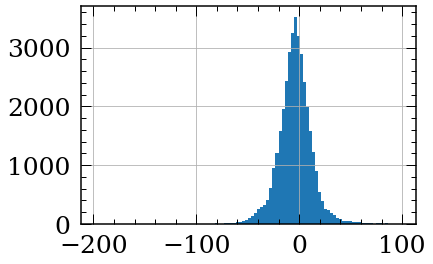

In [61]:
df['v_b'].hist(bins=100)



In [62]:
def m_to_M(m, D):
    """
    Convert apparent magnitude to absolute magnitude.
    """
    return m - 5*np.log10(D)-10

df["abs_G"] = m_to_M(df.phot_g_mean_mag.values, 1./df.parallax.values)
df=df.dropna(subset=["abs_G"])

# For MS stars

Text(0, 0.5, 'logg')

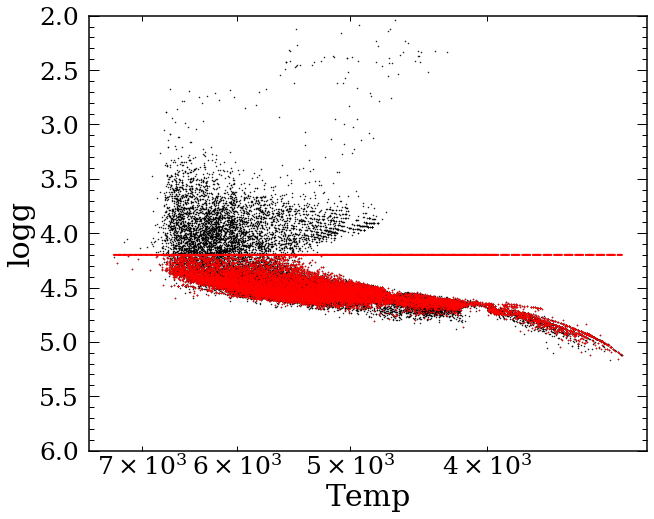

In [63]:
gcut=4.2

z = np.polyfit(df['teff'], df['abs_G'], 6)
p = np.poly1d(z)
df=df.loc[df['w']>0.2]
plt.figure(figsize=(10,8))
plt.semilogx(df['teff'],df['logg_y'],'k.',markersize=1)
#plt.semilogx(df['teff'],p(df['teff'])-0.01,'r.',markersize=1)
plt.plot(df['teff'],gcut*np.ones(len(df['teff'])),'r--')

df_w=df.loc[df['abs_G']>p(df['teff'])-0.01]
df_w=df_w.loc[df_w['logg_y']>gcut]
#df_w=df_w.loc[df_w["abs_G"]>20]
plt.semilogx(df_w['teff'],df_w['logg_y'],'r.',markersize=1)
plt.ylim([2,6])
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.xlabel('Temp')
plt.ylabel('logg')

In [64]:
def Calcdv_bin(df,f1,f2,binsize_temp,binsize_rot):
    Nstars=len(df)
    
    # initialize velocity dispersion
    df['dv_MAD']=np.zeros(Nstars)
    df['dv_STD']=np.zeros(Nstars)
    for i in range(Nstars):
        update_progress(i/Nstars)
        teff = df.iloc[i][f1]
        Prot = df.iloc[i][f2]
        
        
        mask_df1=(df[f1]>teff-binsize_temp/2) & (df[f1]<teff+binsize_temp/2)
        mask_df2=(df[f2]>Prot-binsize_rot/2) & (df[f2]<Prot+binsize_rot/2)
        totmask=mask_df1 & mask_df2

        # get the clossest stadrs v_b
        NNstars=df.loc[totmask]
    
        MAD=sum(abs(NNstars['v_b']-np.median(NNstars['v_b'])))/float(len(NNstars))

        df['dv_MAD'].iloc[i]=1.5*MAD
        df['dv_STD'].iloc[i]=np.std(NNstars['v_b'])


def Calcdv(df,f1,f2,NN):
    Nstars=len(df)
    X_nn = StandardScaler().fit_transform(df[[f1,f2]])
    df[f1+'_norm'],df[f2+'_norm'] = X_nn[:,0], X_nn[:,1]
    
    # initialize velocity dispersion
    df['dv_MAD']=np.zeros(Nstars)
    df['dv_STD']=np.zeros(Nstars)
    for i in range(Nstars):
        update_progress(i/Nstars)
        teff = df.iloc[i][f1+'_norm']
        Prot = df.iloc[i][f2+'_norm']
        df['dist'] = np.sqrt(np.power(df[f1+'_norm']-teff,2.)+np.power(df[f2+'_norm']-Prot,2.))
        
        # get the clossest stadrs v_b
        NNstars=df.loc[df.sort_values(by=['dist']).iloc[0:NN].index]
    
        MAD=sum(abs(NNstars['v_b']-np.median(NNstars['v_b'])))/float(len(NNstars))

        df['dv_MAD'].iloc[i]=1.5*MAD
        df['dv_STD'].iloc[i]=np.std(NNstars['v_b'])

## With NN

In [47]:
NN=270
df_w['Prot_log']=np.log10(df_w['Prot'])
Calcdv(df_w,'teff_calc','Prot_log',NN)

Progress: [####################] 100.0%


Progress: [####################] 100.0%


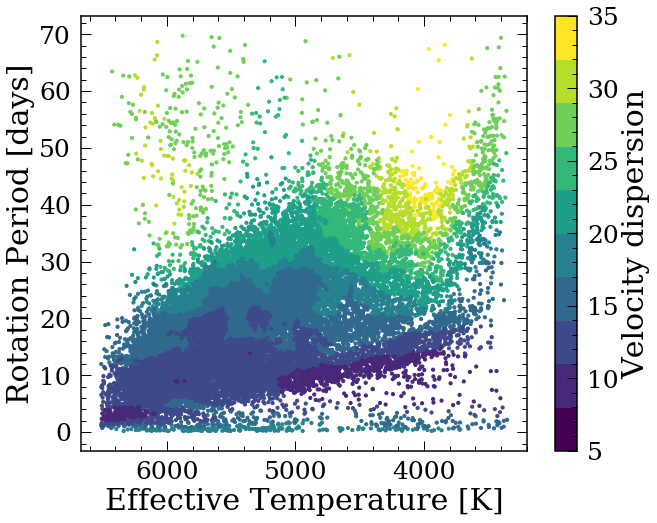

In [48]:
# plot temperature vs Prot
#df_w=pd.read_pickle('ProtVP_cutgiant.pkl')
cm = plt.cm.get_cmap('viridis',10)

plt.figure(figsize=(10,8))
df_w=df_w.dropna(subset=['dv_MAD','dv_STD'])

df_w_err=pd.read_pickle('NNerror.pkl')
dvstderr=np.zeros(len(df_w))

for i in range(len(df_w)):
    update_progress(i/len(df_w))
    temp=df_w.iloc[i]['teff_calc']
    prot=df_w.iloc[i]['Prot']
    df_w_err['dist'] = np.sqrt(np.power(df_w_err['teff']-temp,2.)+np.power(df_w_err['Prot']-prot,2.))
    dvstderr[i]=df_w_err.sort_values(by=['dist']).iloc[0]['dv_error']
df_w['dv_STD_err']=dvstderr


df_plotdv=df_w[['teff_calc','Prot','dv_MAD']].sort_values(by=['dv_MAD'], ascending=False).loc[df_w['kmag']<16.]
plt.scatter(df_plotdv['teff_calc'],df_plotdv['Prot'],c=df_plotdv['dv_MAD'],s=10,vmin=5,vmax=35, cmap=cm,edgecolors=None)

plt.xlabel('Effective Temperature [K]')
plt.gca().invert_xaxis()
plt.ylabel('Rotation Period [days]')

cb=plt.colorbar()
cb.set_label('Velocity dispersion')

plt.savefig('ProtVP_MS_150_w015_NN_MAD.png')

df_w.to_pickle('ProtVP_MS_150_w015_NN.pkl')



In [ ]:
df_w

### With bin & error

In [80]:
def testBin(df,f1,f2,teststari,bintemp,binprot):
    Ntests=int(len(bintemp)*len(binprot))
    teff = df.iloc[teststari][f1]
    Prot = df.iloc[teststari][f2]
    KID = df.iloc[teststari]['KID']
    #print(teff,np.power(10.,Prot))
    
    delta_vz=np.zeros(Ntests)
    temp_a=np.zeros(Ntests)
    prot_a=np.zeros(Ntests)
    stars_inc=np.zeros(Ntests)
    
    maxtemp=max(bintemp)
    maxProt=max(binprot)
    mintemp=min(bintemp)
    minProt=min(binprot)
    
    count=0
    for i in range(len(bintemp)):
        for j in range(len(binprot)):
            #update_progress((count)/Ntests)
        
            mask_df1=(df[f1]>teff-bintemp[i]/2) & (df[f1]<teff+bintemp[i]/2)
            mask_df2=(df[f2]>Prot-binprot[j]/2) & (df[f2]<Prot+binprot[j]/2)
            totmask=mask_df1 & mask_df2

            # get the clossest stadrs v_b
            NNstars=df.loc[totmask]
            stars_inc[count]=len(NNstars)

            if bintemp[i]==maxtemp and binprot[j]==maxProt:
                MaxBin=NNstars
            if bintemp[i]==mintemp and binprot[j]==minProt:
                MinBin=NNstars
            mad=np.median(abs(NNstars['v_b']-np.median(NNstars['v_b'])))
            delta_vz[count]=mad*1.5
            
            count=count+1
            
    return KID,np.median(delta_vz), np.std(delta_vz)


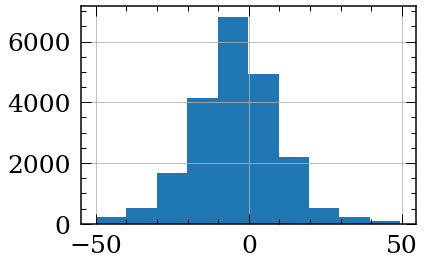

In [75]:
df_w=df_w.loc[df_w['v_b']<50]
df_w=df_w.loc[df_w['v_b']>-50]
df_w['v_b'].hist()

In [81]:
Protbins=[0.04+0.01*i for i in range(17)]
Tempbins=[200+30*i for i in range(15)]
df_w['Prot_log']=np.log10(df_w['Prot'])
df_w=df_w.reset_index(drop=True)
f=open('VD_bin','w+')
f.write('KID, vd, vd_err\n')
sys.stdout.flush()
for i in range(len(df_w)):
    update_progress(i/len(df_w))
    kid, vd,vd_err=testBin(df_w,'teff_calc','Prot_log',i, Tempbins,Protbins)
    f.write(str(kid)+','+str(vd)+','+str(vd_err)+'\n')
    sys.stdout.flush()
    f.flush()

Progress: [####################] 100.0%


## With bin

In [40]:
bintemp=577.27
binprot=0.11
df_w['Prot_log']=np.log10(df_w['Prot'])
Calcdv_bin(df_w,'teff_calc','Prot_log',bintemp,binprot)

Progress: [####################] 100.0%


Progress: [####################] 100.0%


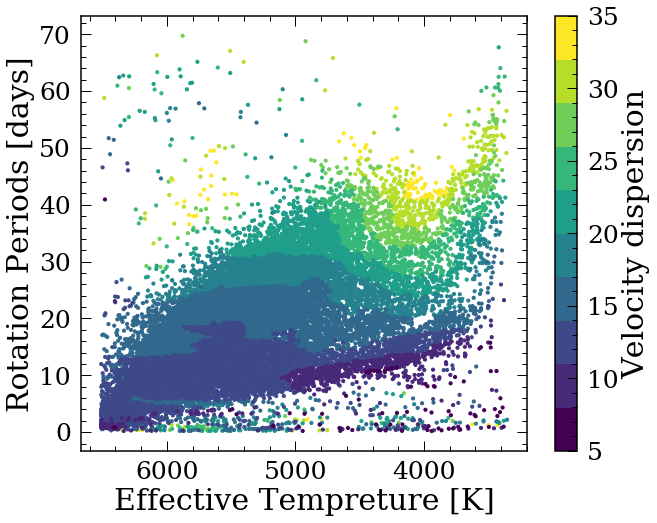

In [41]:
# plot temperature vs Prot
#df_w=pd.read_pickle('ProtVP_cutgiant.pkl')
cm = plt.cm.get_cmap('viridis',10)

plt.figure(figsize=(10,8))
df_w=df_w.dropna(subset=['dv_MAD','dv_STD'])

df_w_err=pd.read_pickle('binerr.pkl')
dvstderr=np.zeros(len(df_w))
for i in range(len(df_w)):
    update_progress(i/len(df_w))
    temp=df_w.iloc[i]['teff_calc']
    prot=df_w.iloc[i]['Prot']
    df_w_err['dist'] = np.sqrt(np.power(df_w_err['teff']-temp,2.)+np.power(df_w_err['Prot']-prot,2.))
    dvstderr[i]=df_w_err.sort_values(by=['dist']).iloc[0]['dv_error']
df_w['dv_MAD_err']=dvstderr

df_plotdv=df_w[['teff_calc','Prot','dv_MAD']].sort_values(by=['dv_MAD'], ascending=False).loc[df_w['kmag']<16.]
plt.scatter(df_plotdv['teff_calc'],df_plotdv['Prot'],c=df_plotdv['dv_MAD'],s=10,vmin=5,vmax=35, cmap=cm,edgecolors=None)

plt.xlabel('Effective Tempreture [K]')
plt.gca().invert_xaxis()
plt.ylabel('Rotation Periods [days]')

cb=plt.colorbar()
cb.set_label('Velocity dispersion')

In [46]:
plt.savefig('ProtVP_MS_150_w015_bin_MAD.png')

df_w.to_pickle('ProtVP_MS_150_w015_bin.pkl')

<Figure size 432x288 with 0 Axes>

# For giants

Text(0, 0.5, 'abs_g')

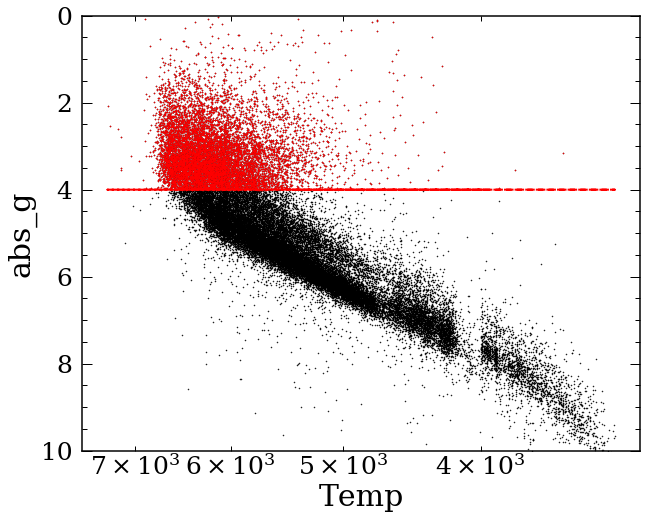

In [36]:
plt.figure(figsize=(10,8))
plt.semilogx(df['teff'],df['abs_G'],'k.',markersize=1)
plt.plot(df['teff'],4*np.ones(len(df['teff'])),'r--')

df_w_giants=df.loc[df['abs_G']<4]

plt.semilogx(df_w_giants['teff'],df_w_giants['abs_G'],'r.',markersize=1)
plt.ylim([0,10])
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.xlabel('Temp')
plt.ylabel('abs_g')

## With NN

In [42]:
NN=200
df_w_giants['Prot_log']=np.log10(df_w_giants['Prot'])
df_w_giants=df_w_giants.loc[df_w_giants.teff_calc>4000]
df_w_giants=df_w_giants.loc[df_w_giants.teff_calc<7000]
Calcdv(df_w_giants,'teff_calc','Prot_log',NN)


Progress: [####################] 100.0%


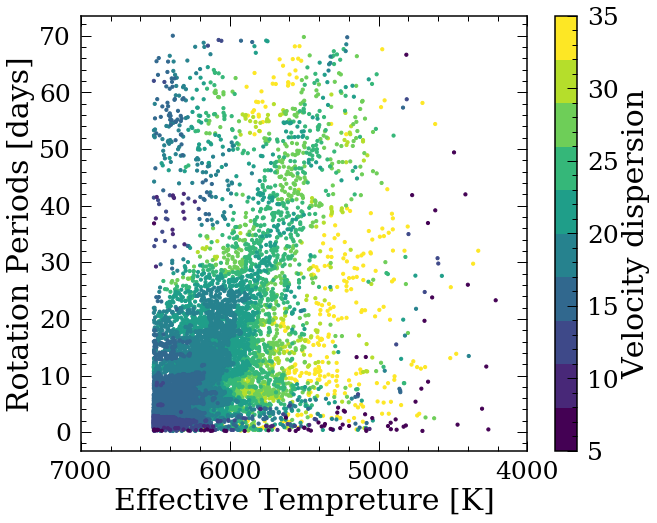

In [59]:
# plot tempreture vs Prot
#df_w=pd.read_pickle('ProtVP_cutgiant.pkl')
cm = plt.cm.get_cmap('viridis',10)

plt.figure(figsize=(10,8))
df_w_giants=df_w_giants.dropna(subset=['dv_MAD','dv_STD'])

df_plotdv=df_w_giants[['teff_calc','Prot','dv_MAD']].sort_values(by=['dv_MAD'], ascending=False).loc[df_w_giants['kmag']<16.]
plt.scatter(df_plotdv['teff_calc'],df_plotdv['Prot'],c=df_plotdv['dv_MAD'],s=10,vmin=5,vmax=35, cmap=cm,edgecolors=None)

plt.xlabel('Effective Tempreture [K]')
plt.xlim([4000,7000])
plt.gca().invert_xaxis()
plt.ylabel('Rotation Periods [days]')
cb=plt.colorbar()
cb.set_label('Velocity dispersion')

plt.savefig('ProtVP_Giant_200_w015_NN_MAD.png')

df_w_giants.to_pickle('ProtVP_Giant_200_w015_NN.pkl')




## With bin

In [49]:
bintemp=200
binprot=0.1

Calcdv_bin(df_w_giants,'teff_calc','Prot_log',bintemp,binprot)


Progress: [####################] 100.0%


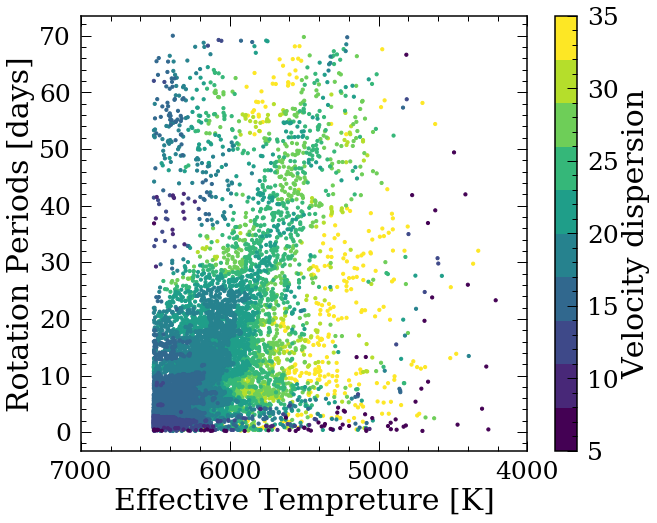

In [58]:
# plot tempreture vs Prot
#df_w=pd.read_pickle('ProtVP_cutgiant.pkl')
cm = plt.cm.get_cmap('viridis',10)

plt.figure(figsize=(10,8))
df_w_giants=df_w_giants.dropna(subset=['dv_MAD','dv_MAD'])

df_plotdv=df_w_giants[['teff_calc','Prot','dv_MAD']].sort_values(by=['dv_MAD'], ascending=False).loc[df_w_giants['kmag']<16.]
plt.scatter(df_plotdv['teff_calc'],df_plotdv['Prot'],c=df_plotdv['dv_MAD'],s=10,vmin=5,vmax=35, cmap=cm,edgecolors=None)

plt.xlabel('Effective Tempreture [K]')
plt.xlim([4000,7000])
plt.gca().invert_xaxis()
plt.ylabel('Rotation Periods [days]')

cb=plt.colorbar()
cb.set_label('Velocity dispersion')

plt.savefig('ProtVP_Giant_w015_bin_MAD.png')

df_w_giants.to_pickle('ProtVP_Giant_w015_bin.pkl')






# Get ages

15 15 15
5.753894006999593 0.35657880209357806 -10.905913959223207


Text(0.5, 1.0, '|z|>270')

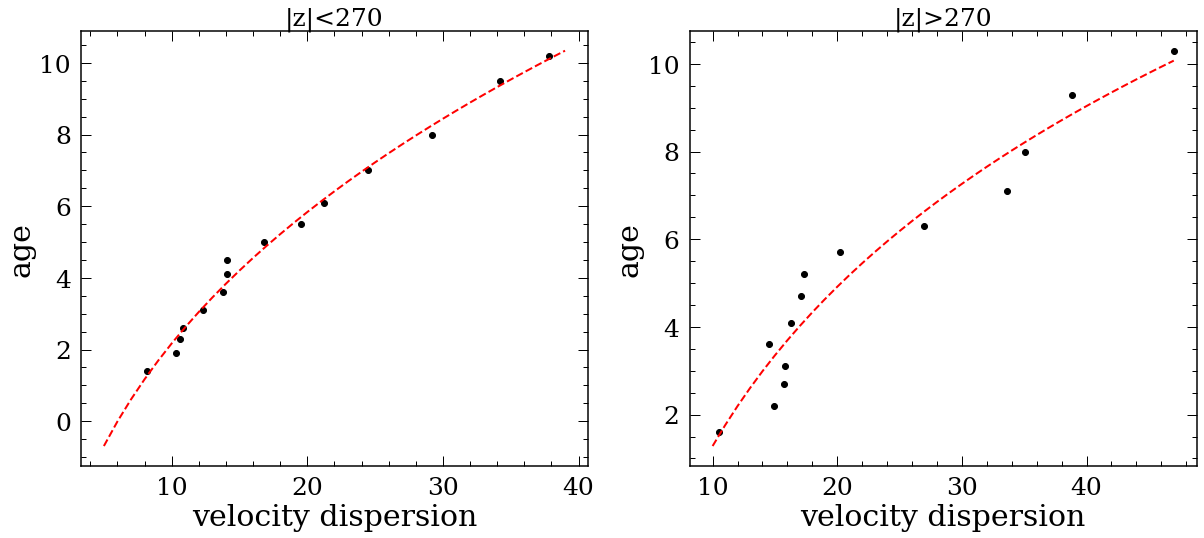

In [43]:
from scipy.optimize import curve_fit
dv_lowz=[8.2,10.3,10.6,10.8,12.3,13.8,14.1,14.1,16.8,19.5,21.2,24.5,29.2,34.2,37.8]
age_lowz=[1.4,1.9,2.3,2.6,3.1,3.6,4.1,4.5,5.,5.5,6.1,7.0,8.,9.5,10.2]
age_lowz_err=[0.3,0.3,0.2,0.2,0.2,0.3,0.3,0.3,0.3,0.4,0.5,0.5,0.6,0.7,0.5]
print(len(dv_lowz),len(age_lowz),len(age_lowz_err))
def AVD(vd, alpha,beta,c):
    return alpha * np.power(vd,beta)+c

def age_err(vd,alpha,beta,c,d_alpha,d_beta,d_c):
    sigma_alpha=np.power(vd,beta)*d_alpha
    sigma_beta=np.power(vd,beta)*alpha*beta*d_beta
    sigma_c=d_c
    return np.sqrt(np.power(sigma_alpha,2)+np.power(sigma_beta,2)+np.power(sigma_c,2))

popt_lowz, pcov_lowz = curve_fit(AVD, dv_lowz, age_lowz)
perr_lowz = np.sqrt(np.diag(pcov_lowz))

a_true,b_true,c_true=popt_lowz[0],popt_lowz[1],popt_lowz[2]

print(a_true,b_true,c_true)

plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.plot(dv_lowz,age_lowz,'ko')
plt.plot(range(5,40),AVD(range(5,40),*popt_lowz),'r--')
plt.xlabel('velocity dispersion')
plt.ylabel('age')
plt.title('|z|<270',fontsize=25)

dv_hiz=[10.5,14.9,15.7,15.8,14.5,16.3,17.1,17.3,20.2,27.,33.6,35.1,38.8,47]
age_hiz=[1.6,2.2,2.7,3.1,3.6,4.1,4.7,5.2,5.7,6.3,7.1,8.,9.3,10.3]

popt_hiz, pcov_hiz = curve_fit(AVD, dv_hiz, age_hiz)
perr_hiz = np.sqrt(np.diag(pcov_hiz))

plt.subplot(1,2,2)
plt.plot(dv_hiz,age_hiz,'ko')
plt.plot(range(10,48),AVD(range(10,48),*popt_hiz),'r--')
plt.xlabel('velocity dispersion')
plt.ylabel('age')
plt.title('|z|>270',fontsize=25)



### MCMC

In [44]:
def log_likelihood(theta, x, y, yerr):
    a, b, c = theta
    model = AVD(x,a,b,c)
    sigma2 = yerr ** 2 
    return -0.5 * np.sum((y - model) ** 2 / sigma2)

from scipy.optimize import minimize

np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([a_true,b_true,c_true]) + 0.1 * np.random.randn(3)
soln = minimize(nll, initial, args=(np.array(dv_lowz), np.array(age_lowz), np.array(age_lowz_err)))


a_ml, b_ml, c_ml  = soln.x

print(a_ml, b_ml, c_ml)
print(a_true, b_true, c_true)

9.067034965757262 0.2828112987127466 -15.253817546329195
5.753894006999593 0.35657880209357806 -10.905913959223207


In [136]:
import emcee
"""
def log_prior(theta):
    a, b, c = theta
    if -10 < a < 20 and 0.2 < b < 0.35 and -30 < c < 10:
        return 0.0
    return -np.inf
"""
def log_prior(theta):
    a, b, c = theta
    if 8.85 < a < 9.15 and -30 < c < 10:
        return 0
    return -np.inf

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

pos = soln.x + 1e-6 * np.random.randn(32, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(np.array(dv_lowz), np.array(age_lowz), np.array(age_lowz_err)))
sampler.run_mcmc(pos, 1e4, progress=True);

100%|██████████| 10000/10000 [00:11<00:00, 845.45it/s]


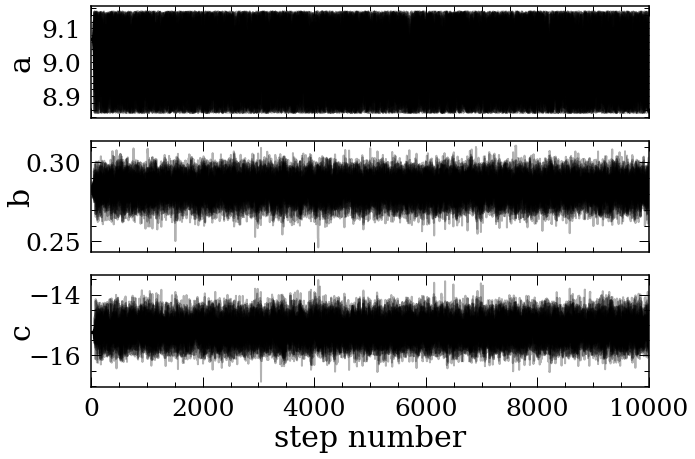

In [137]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["a", "b", "c"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

[54.77960223 43.75865934 44.11435284]
(21120, 3)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

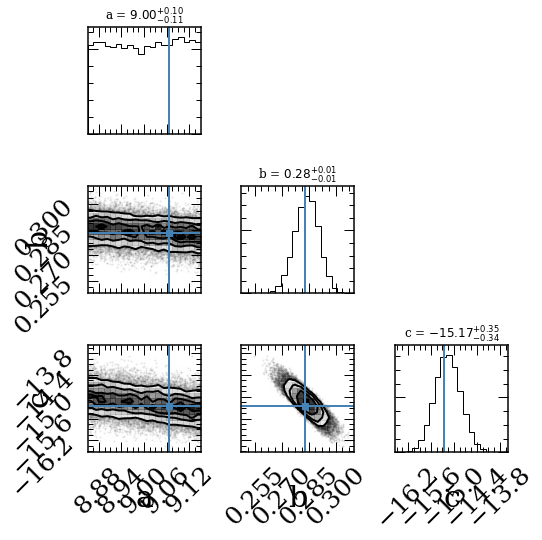

In [138]:
tau = sampler.get_autocorr_time()
print(tau)

flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

import corner

fig = corner.corner(flat_samples, labels=labels, truths=[a_ml, b_ml, c_ml],figsize=(20,16),show_titles=True, title_kwargs={"fontsize": 12} )
plt.tight_layout()
plt.savefig("MCMC")

In [139]:
from IPython.display import display, Math
theta=np.zeros(3)
theta_err=np.zeros(3)
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    theta[i]=mcmc[1]
    theta_err[i]=(abs(q[0])+abs(q[1]))/2.
    display(Math(txt))
print(theta)
print(theta_err)

np.save('Figures/AVtheta.npy',theta)
np.save('Figures/AVtheta_err.npy',theta_err)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

[  9.00320811   0.28388155 -15.1689971 ]
[0.10306229 0.00662335 0.34296342]


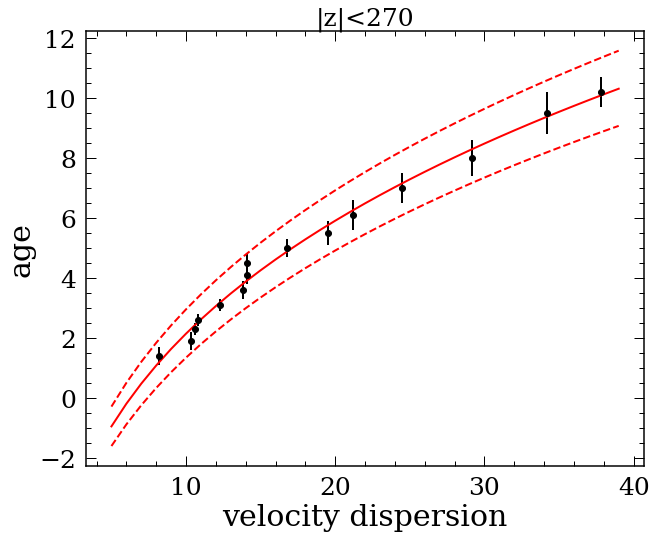

In [141]:
plt.figure(figsize=(10,8))
plt.errorbar(dv_lowz,age_lowz,yerr=age_lowz_err,fmt='ko')
plt.plot(range(5,40),AVD(range(5,40),*theta),'r-')
plt.plot(range(5,40),AVD(range(5,40),*(theta+theta_err)),'r--')
plt.plot(range(5,40),AVD(range(5,40),*(theta-theta_err)),'r--')
plt.xlabel('velocity dispersion')
plt.ylabel('age')
plt.title('|z|<270',fontsize=25)
#np.save('Figures/dv_lowz.npy',dv_lowz)
#np.save('Figures/age_lowz.npy',age_lowz)
#np.save('Figures/age_lowz_err.npy',age_lowz_err)

In [51]:
mpf = 'aviary/data/metal_poor_avr.csv'
mrf = 'aviary/data/metal_rich_avr.csv'
af = 'aviary/data/all_stars_avr.csv'
def get_avr_coefficients():
    """
    Fit the parameters of the AVR using data from Yu & Liu:
    https://arxiv.org/pdf/1712.03965.pdf
    Fit to the relationship between log(sigma_z) and age.
    Returns:
        p_mp (array): coefficients [slope, intercept] for straight line fit to
            metal poor stars.
        p_mr (array): coefficients [slope, intercept] for straight line fit to
            metal rich stars.
        p_a (array): coefficients [slope, intercept] for straight line fit to
            all stars.
    """
    mp = pd.read_csv(mpf)
    mr = pd.read_csv(mrf)
    a = pd.read_csv(af)

    p_mp = np.polyfit(np.log(mp.sigma_z_kms), np.log(mp.Age_Gyr), 1)
    p_mr = np.polyfit(np.log(mr.sigma_z_kms), np.log(mr.Age_Gyr), 1)
    p_a = np.polyfit(np.log(a.sigma_z_kms), np.log(a.Age_Gyr), 1)

    return p_mp, p_mr, p_a

def v_to_age(v, coeffs):
    """
    Convert z velocity dispersion [km/s] to age [Gyr]
    Args:
        v (array): Z Velocity dispersion [km/s].
        coeffs (array): coefficients for straight line fit. [intercept, slope]
    Returns:
        age (array): age in Gyr.
    """
    b, a = coeffs
    logt = np.polyval(coeffs, np.log(v))
    return np.exp(logt)

/Users/lucy/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/lucy/anaconda3/lib/python3.7/site-packages/numpy/lib/polynomial.py:675: RuntimeWarning: invalid value encountered in multiply
  y = y * x + p[i]


0.10996489806101645
NewData/ProtVP_MS_150_w015_bin.pkl


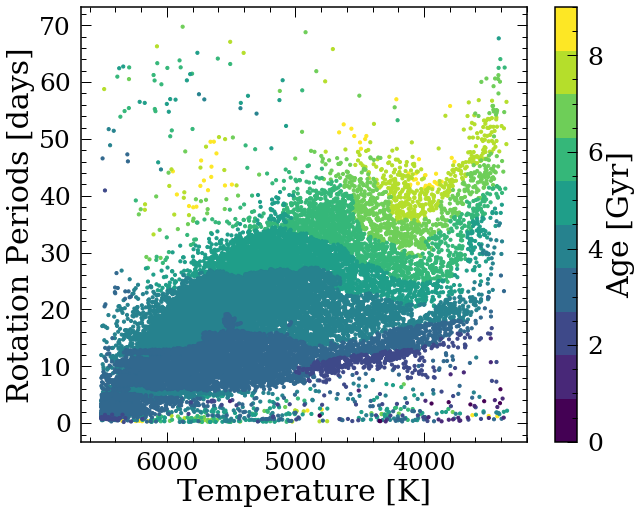

In [52]:
fname='ProtVP_MS_150_w015_bin.pkl'
theta=[9.00320811,0.28388155,-15.1689971 ]
theta_err=[0.10306229,0.00662335,0.34296342]
df_w=pd.read_pickle(fname)

#df_w['age_MAD']=AVD(df_w['dv_MAD'],*theta)
p_mp, p_mr, p_a = get_avr_coefficients()
df_w['age_MAD']=v_to_age(df_w['dv_MAD'],p_mp)

df_w['age_model_err']=abs(df_w['dv_MAD_err'])*df_w['age_MAD']
df_w['age_fit_err']=age_err(df_w['dv_MAD'],*theta,*theta_err)

df_w['age_MAD_err']=np.sqrt(np.power(df_w['age_model_err'],2.)+np.power(df_w['age_fit_err'],2.))

df_w['age_STD']=AVD(df_w['dv_STD'],*theta)

df_w=df_w.replace([np.inf, -np.inf], np.nan)
df_w=df_w.dropna(subset=['teff_calc','Prot','age_MAD','abs_G','age_MAD_err'])
#df_w_giants['age_Prot']=p_lowz(df_w_giants['dv_STD'])

# plot tempreture vs Prot
cm = plt.cm.get_cmap('viridis',10)
plt.figure(figsize=(10,8))
df_w=df_w.dropna(subset=['dv_MAD'])
df_plotdv=df_w[['teff_calc','Prot','age_MAD','abs_G']].sort_values(by=['age_MAD'], ascending=False).loc[df_w['kmag']<16.]
plt.scatter(df_plotdv['teff_calc'],df_plotdv['Prot'],c=df_plotdv['age_MAD'],s=10,vmin=0,vmax=9,cmap=cm,edgecolors=None)

plt.xlabel('Temperature [K]')
plt.gca().invert_xaxis()
plt.ylabel('Rotation Periods [days]')

cb=plt.colorbar()
cb.set_label('Age [Gyr]')

#plt.savefig('150stars_wogiant_age.png')
print(np.median(df_w['age_MAD_err']/df_w['age_MAD']))
print('NewData/'+fname)
df_w.to_pickle('NewData/'+fname)



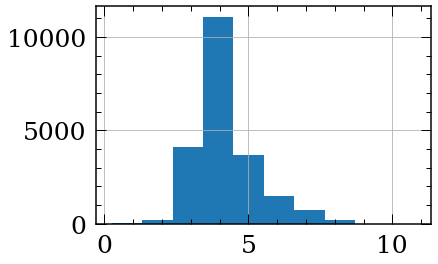

In [56]:
df_w['age_MAD'].hist()

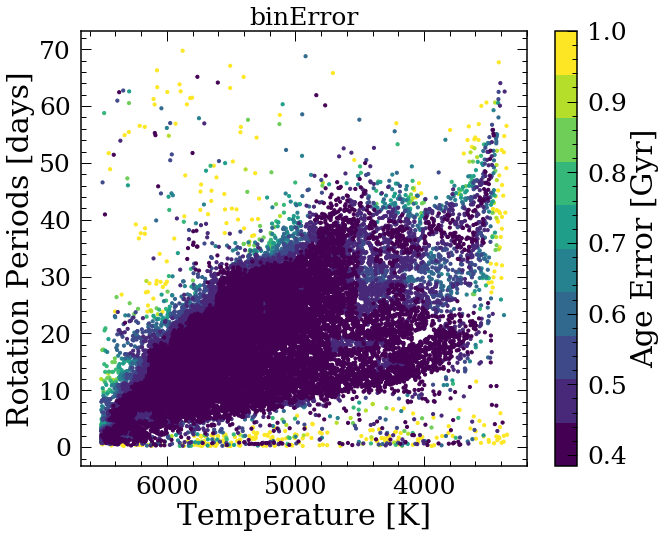

In [48]:
cm = plt.cm.get_cmap('viridis',10)
plt.figure(figsize=(10,8))
df_w=df_w.dropna(subset=['dv_MAD'])
df_plotdv=df_w[['teff_calc','Prot','age_MAD_err','abs_G']].sort_values(by=['age_MAD_err'], ascending=False).loc[df_w['kmag']<16.]
plt.scatter(df_plotdv['teff_calc'],df_plotdv['Prot'],c=df_plotdv['age_MAD_err'],s=10,vmax=1,cmap=cm,edgecolors=None)

plt.xlabel('Temperature [K]')
plt.gca().invert_xaxis()
plt.ylabel('Rotation Periods [days]')

cb=plt.colorbar()
cb.set_label('Age Error [Gyr]')
plt.title('binError',fontsize=25)
plt.savefig('binError.png')

In [35]:
df_w['age_STD_err']

1        0.499097
2        0.527122
4        0.543778
5        0.450433
6        0.472922
           ...   
62827    0.519118
62835    0.610173
62845    0.476273
62848    0.457456
62849    0.411658
Name: age_STD_err, Length: 25231, dtype: float64

In [38]:
df_w['age_model_err']

1        0.299051
2        0.318729
4        0.339979
5        0.118663
6        0.223598
           ...   
62827    0.326146
62835    0.458627
62845    0.210923
62848    0.191352
62849    0.042979
Name: age_model_err, Length: 25231, dtype: float64

In [44]:
np.median(df_w['age_model_err'])

0.15363082089199098